
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load EPEACS module
from epeacs.agents.epeacs import EPEACS, Configuration

from epeacs.agents.epeacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from epeacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population, \
    _enhanced_effect_error

# Load environments
import gym
import my_mazes

# Agent - EPEACS

## Common parameters

In [2]:
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "MazeE2-v0"

NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 20
BETA_ALP = 0.05
BETA_RL = 0.05
BETA_PEP = 0.01
EPSILON = 0.8

DO_GA = False
ENABLE_PEP = True

SLIPPERY_PROB = 0.

NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00

NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05

NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ ■ ■ ■
■ ■ ■ □ □ □ A ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of EPEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = EPEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 1h 2min 57s, sys: 7.86 s, total: 1h 3min 5s
Wall time: 1h 3min 45s


### Performance

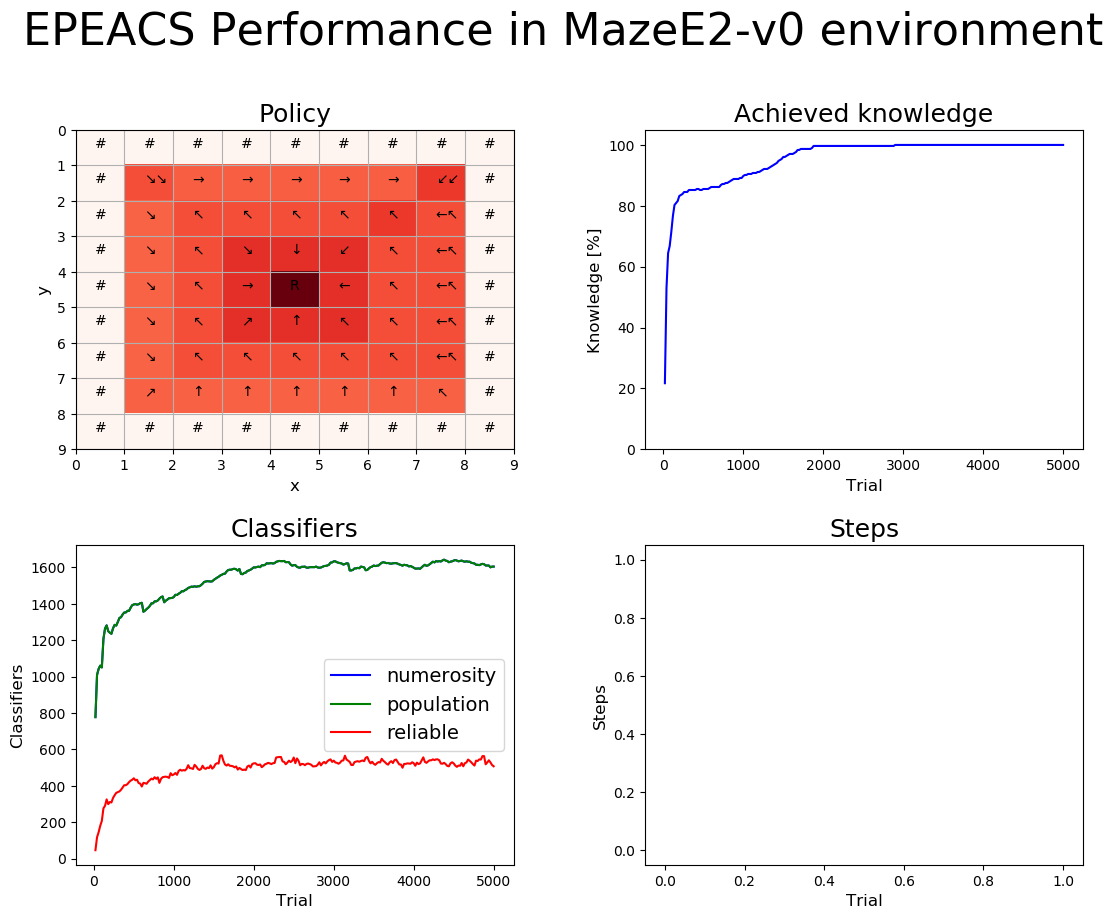

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze))

first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, last_trial, METRICS_TRIAL_FREQUENCY_EXPLORE))

old_error, new_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities : old->", old_error, "% new->", new_error, "%")

{'knowledge': 100.0, 'population': 1604, 'numerosity': 1604, 'reliable': 507}
Full knowledge was achieved at trials  2900 , was stable at  2900  and the last time it was achieved at  5000
There are  0  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.5525147928994083
{'trial': 5000, 'steps_in_trial': 13, 'reward': 1000, 'knowledge': 100.0, 'population': 1604, 'numerosity': 1604, 'reliable': 507}
Accumulated Error on PEP Probabilities : old-> 2.151767078054694 % new-> 1.2559251877313284 %


In [7]:
population_explore.sort(key=lambda cl: -cl.exp * cl.num)
population_explore_to_display = [(cl.condition, cl.action, cl.effect, cl.exp, cl.num) for cl in population_explore
    if cl.is_reliable() and cl.is_enhanced()]
for cl in population_explore_to_display:
    print(cl)
    print(cl[2].print_detailled_counter())
    print("\n")

(00000000, 1, {0:59.22% (67.56%), 1:40.78% (32.44%)}{1:53.97% (60.85%), 0:35.98% (32.49%), 9:10.05% (6.66%)}{0:48.74% (57.80%), 1:40.89% (34.92%), 9:10.37% (7.28%)}{0:49.77% (60.17%), 1:41.42% (34.93%), 9:8.81% (4.89%)}###{0:54.50% (61.28%), 1:37.33% (32.43%), 9:8.17% (6.29%)}, 4288, 1)
11000001:#1044, 00090000:#196, 00900000:#291, 00000000:#567, 01110000:#1144, 00000009:#252, 09000000:#266, 11110001:#260


(00000000, 1, {0:58.52% (65.41%), 1:41.48% (34.59%)}{1:55.22% (64.90%), 0:34.04% (28.00%), 9:10.75% (7.10%)}{0:47.72% (55.00%), 1:41.54% (37.26%), 9:10.74% (7.74%)}{0:48.80% (57.52%), 1:42.08% (37.26%), 9:9.13% (5.22%)}###{0:58.52% (65.41%), 1:41.48% (34.59%)}, 4287, 1)
11000001:#1043, 00090000:#196, 00900000:#291, 00000000:#567, 01110000:#1144, 09000000:#266, 11110001:#260


(00000000, 1, {0:54.78% (63.12%), 1:36.36% (30.56%), 9:8.87% (6.31%)}{1:52.71% (57.15%), 0:37.86% (36.63%), 9:9.43% (6.22%)}{0:49.84% (60.38%), 1:40.17% (32.79%), 9:9.99% (6.83%)}{0:50.81% (62.66%), 1:40.70% (3

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '0', '0', '0', '0', '0')]

## Training of EPEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = EPEACS(cfg_exploit_no_rl, population_explore)
#agent_exploit_no_rl.zip_population()
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 2min 56s, sys: 209 ms, total: 2min 56s
Wall time: 2min 57s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = EPEACS(cfg_exploit_rl_start, population_exploit_no_rl)
#agent_exploit_rl_start.zip_population()
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 1min 50s, sys: 158 ms, total: 1min 50s
Wall time: 1min 51s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = EPEACS(cfg_exploit_rl, population_exploit_rl_start)
#agent_exploit_rl.zip_population()
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 1min 49s, sys: 130 ms, total: 1min 49s
Wall time: 1min 50s


### Performance

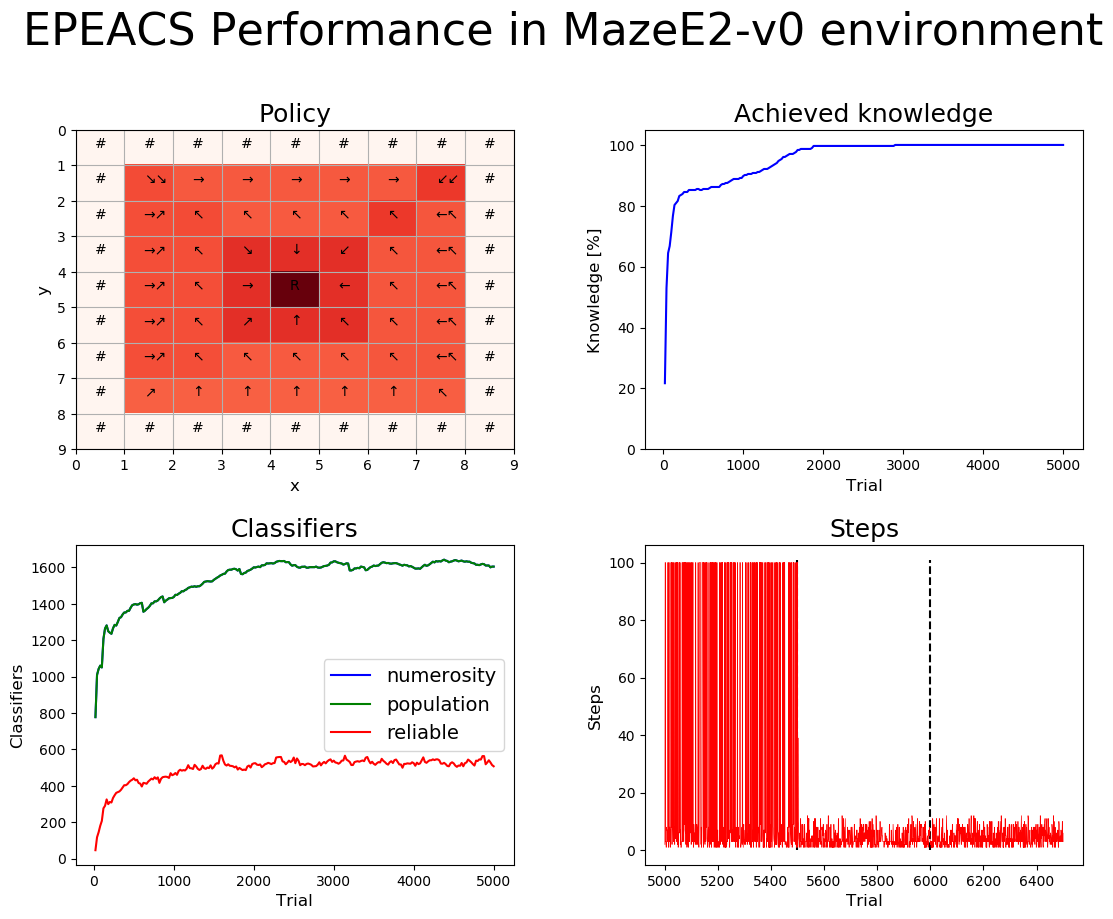

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  31.3  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  34.01  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  4.306  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  4.578  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 1604, 'numerosity': 1604, 'reliable': 507}
{'knowledge': 100.0, 'population': 1604, 'numerosity': 1604, 'reliable': 507}
{'knowledge': 100.0, 'population': 1604, 'numerosity': 1604, 'reliable': 507}
{'knowledge': 100.0, 'population': 1604, 'numerosity': 1604, 'reliable': 507}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.q)
population_exploit_rl_to_display = [(cl.condition, cl.action, cl.behavioral_sequence, cl.effect, cl.mark, cl.q, cl.exp, cl.ee) 
    for cl in population_exploit_rl if cl.behavioral_sequence]
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

(00#00111, 3, [2], ##9##000, empty, 0.9999999999999989, 2, False)


(#0#11100, 7, [7], 9#0000##, empty, 0.9999999999999989, 1, False)


(00##0111, 1, [4], ##00#000, empty, 0.9999999999999989, 1, False)


(#0011100, 0, [7], 0##000#9, empty, 0.9999999999999989, 1, False)


(00900000, 5, [7], ##0##111, empty, 0.9999999993218478, 36, False)


(90000000, 3, [5], 0##111##, empty, 0.9999999843215238, 75, False)


(000900#0, 5, [7], ###0#111, empty, 0.9999999740230037, 35, False)


(#11111##, 7, [4], #00#####, empty, 0.9999999197084916, 53, False)


(#000090#, 7, [7], 11###0#1, empty, 0.9999997642379461, 31, False)


(9000#000, 3, [3], 0##111##, empty, 0.999999232937088, 75, False)


(000900#0, 5, [5], ###0#111, empty, 0.999999232937088, 57, False)


(#11111##, 7, [1], ####00##, empty, 0.9999989565074493, 84, False)


(#0000900, 7, [1], 11###0#1, empty, 0.9999988721999781, 81, False)


(11###111, 3, [6], 00######, empty, 0.9999987829216497, 71, False)


(111100#1, 5, [5], 0000#9#0, empty, 0.99